# Character classification using NNs with PyTorch

##### Step 1: Data acquisition + cleanup

In [183]:
# load font
import pandas as pd
from webencodings import labels

df = pd.read_csv("data/BERLIN.csv")
print(df.shape)
print(df.columns)

(2012, 412)
Index(['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation',
       'm_top', 'm_left', 'originalH', 'originalW',
       ...
       'r19c10', 'r19c11', 'r19c12', 'r19c13', 'r19c14', 'r19c15', 'r19c16',
       'r19c17', 'r19c18', 'r19c19'],
      dtype='object', length=412)


In [269]:
from typing import Tuple, List
import numpy as np
from sklearn.preprocessing import scale

# Map of structure {<original label>: <label index>}
LABEL_MAP = dict(zip(df['m_label'].unique(), range(df['m_label'].nunique())))

def concat_tensors(a: np.array, b: np.array) -> np.array:
    return np.concatenate((a, b), axis=1)

def get_cols(row: int) -> List[str]:
    return [f"r{row}c{col}" for col in range(20)]

def rows_as_tensor(df: pd.DataFrame, row: int) -> np.array:
    return np.expand_dims(scale(df[get_cols(row)].values), axis=1)

def extract_images(df: pd.DataFrame, label_map) -> Tuple[np.array, np.array]:
    images = rows_as_tensor(df, 0)
    for col in range(1, 20):
        images = concat_tensors(images, rows_as_tensor(df, col))
    return images, df['m_label'].map(label_map).values

In [270]:
X, y = extract_images(df, LABEL_MAP)

##### Step 2: Build a Pytorch Network

In [186]:
X.shape

(2012, 20, 20)

In [218]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class ConvNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        c1Out = 6
        c2Out = 16

        # Note: feature map outsize = (input size - filter size + 2 * Padding) // Stride + 1
        # > with default params and 3x3 kernel: outsize = (input size - 2)
        self.conv1 = nn.Conv2d(1, c1Out, 3) # (20-2)*(20-2)=18x18
        self.pool1 = nn.MaxPool2d(2, 2) # output =  18 / 2 = 9x9 feature map
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) # (9-2)*(9-2)=7x7
        self.pool2 = nn.MaxPool2d(2, 2) # output =  7 // 2 = 3x3 feature map

        self.pooledOutputSize = c2Out*3*3 # Last max pool resulted in reducing c2Out feature maps to 3x3
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x)) # Flatten data for dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [219]:
device = ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
net = ConvNet(num_classes=len(LABEL_MAP)).to(device)

Device:  mps


In [220]:
import torch.optim as optim
from torch.utils.data.dataloader import default_collate

def train(model, epochs, data_train):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr= 1e-4)

    #this loads data and gets it in the right format for us
    trainloader = torch.utils.data.DataLoader(data_train, batch_size=8,
                                              shuffle=True, num_workers=0,
                                              collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def evaluate(model, data_test):
    #load some test data
    testloader = torch.utils.data.DataLoader(data_test, batch_size=8,
                                                shuffle=True, num_workers=0,
                                                collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #just do a coarse evaluation... how many did we predict correcly?
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [227]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

def split_data(x_raw, y_raw):
    x_raw = np.reshape(x_raw, (-1, 1, 20, 20)) # Reshape for pytorch tensor compatibility (batch, channels, height, width)
    data = train_test_split(x_raw, y_raw, test_size=0.2, stratify=y_raw)

    return (torch.from_numpy(dset).float() for dset in data)

X_train, X_test, y_train, y_test = split_data(X, y)

train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

##### Step 3: Exploration and Evaluation

In [228]:
train(net, 50, train_set)
evaluate(net, test_set)

Finished Training
Accuracy of the network on the 10000 test images: 34 %


In [248]:
class NewNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        c1Out = 6
        c2Out = 16
        c3Out = 32

        # Note: feature map outsize = (input size - filter size + 2 * Padding) // Stride + 1
        # > with default params and 3x3 kernel: outsize = (input size - 2)
        self.conv1 = nn.Conv2d(1, c1Out, 3, padding=1) # Include padding to preserve feature size (20x20)
        self.pool1 = nn.MaxPool2d(2, 2) # output =  20 / 2 = 10x10 feature map
        self.norm1 = nn.BatchNorm2d(c1Out)
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3, padding=1) # Include padding to preserve feature size (10x10)
        self.pool2 = nn.MaxPool2d(2, 2) # output =  10 // 2 = 5x5 feature map
        self.norm2 = nn.BatchNorm2d(c2Out)
        self.conv3 = nn.Conv2d(c2Out, c3Out, 3, padding=1)  # Include padding to preserve feature size (5x5)
        self.pool3 = nn.MaxPool2d(2, 1) # output = (5-2)/1+1 = 4
        self.norm3 = nn.BatchNorm2d(c3Out)

        self.pooledOutputSize = c3Out*4*4
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, num_classes)

    def forward(self, x):
        x = self.norm1(self.pool1(F.relu(self.conv1(x))))
        x = self.norm2(self.pool2(F.relu(self.conv2(x))))
        x = self.norm3(self.pool3(F.relu(self.conv3(x))))
        x = x.view(-1, self.num_flat_features(x)) # Flatten data for dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

new_net = NewNet(num_classes=len(LABEL_MAP)).to(device)

In [249]:
# train and evaluate new network architecture (previous accuracy: 34%)
train(new_net, 50, train_set)
evaluate(new_net, test_set)

Finished Training
Accuracy of the network on the 10000 test images: 44 %


In [267]:
# Test new net with different font
new_X, new_y = extract_images(pd.read_csv("data/ITALIC.csv"))

# Get filter mask for classes which are not contained in the original training set
mask = [label in LABEL_MAP.values() for label in new_y]

def tensor_from_numpy(x_raw, y_raw):
    x_raw = np.reshape(x_raw, (-1, 1, 20, 20))
    return TensorDataset(torch.from_numpy(x_raw).float(), torch.from_numpy(y_raw).float())

new_font_data_set = tensor_from_numpy(new_X[mask], new_y[mask])

In [268]:
evaluate(new_net, new_font_data_set)

Accuracy of the network on the 10000 test images: 5 %


The performance of the new network on a DIFFERENT font is very poor with an accuracy of 5%

In [287]:
# Train the network using different fonts together
italic_df = pd.read_csv("data/ITALIC.csv")

combined_df = pd.concat([df, italic_df])

COMBINED_LABEL_MAP = dict(zip(combined_df['m_label'].unique(), range(combined_df['m_label'].nunique())))

combined_X, combined_y = extract_images(combined_df, COMBINED_LABEL_MAP)

combined_X_train, combined_X_test, combined_y_train, combined_y_test = split_data(combined_X, combined_y)

combined_train_set = TensorDataset(combined_X_train, combined_y_train)
combined_test_set = TensorDataset(combined_X_test, combined_y_test)

combined_net = NewNet(num_classes=len(COMBINED_LABEL_MAP)).to(device)

In [289]:
train(combined_net, 50, combined_train_set)

Finished Training


In [319]:
print("Evaluation of combined fonts:")
evaluate(combined_net, combined_test_set)

Evaluation of combined fonts:
Accuracy of the network on the 10000 test images: 32 %


In [328]:
import matplotlib.pyplot as plt

incorrect_images = []
incorrect_labels = []
incorrect_preds = []
with torch.no_grad():
    for image, label in combined_train_set:
        image = image.unsqueeze(0).to(device) # Adding batch dim for feed forward
        label = label.to(device)

        output = combined_net(image)
        pred = torch.argmax(output, dim=1)

        if pred.item() != label.item():
            incorrect_images.append(image.cpu().squeeze(0).numpy())
            incorrect_labels.append(label.cpu())
            incorrect_preds.append(pred.cpu())

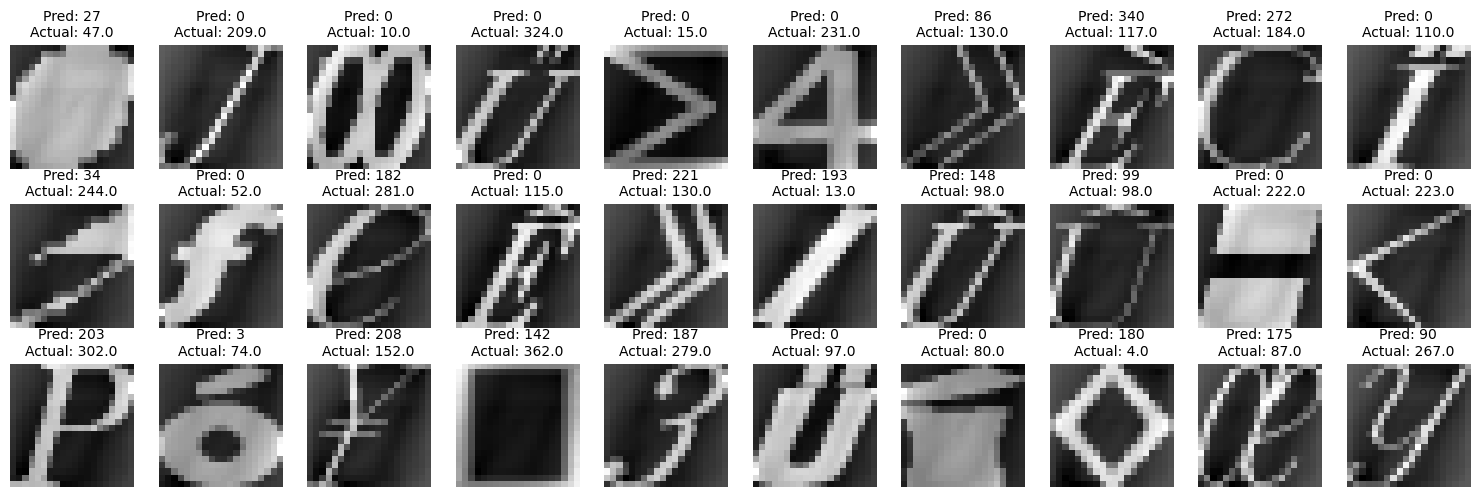

In [334]:
fig = plt.figure(figsize=(15, 5))
for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    plt.imshow(incorrect_images[i][0], cmap='gray')
    ax.set_title(f"Pred: {incorrect_preds[i].item()}\nActual: {incorrect_labels[i].item()}", fontsize=10)
    ax.axis('off')
plt.tight_layout()

It appears quite a bit of the italicized fonts are being misclassified.
we are also seeing the same characters be consistently misclassified such as the italic "E" or "U"

In [336]:
uncertain_images = []
with torch.no_grad():
    for image, label in combined_test_set:
        image = image.unsqueeze(0).to(device)
        label = label.to(device)
        output = combined_net(image)
        probs = F.softmax(output, dim=1)

        top_probs, top_classes = probs.topk(2, dim=1)
        diff = (top_probs[0][0] - top_probs[0][1]).item()

        if diff < 0.05:
            uncertain_images.append(image.cpu().squeeze(0).numpy())

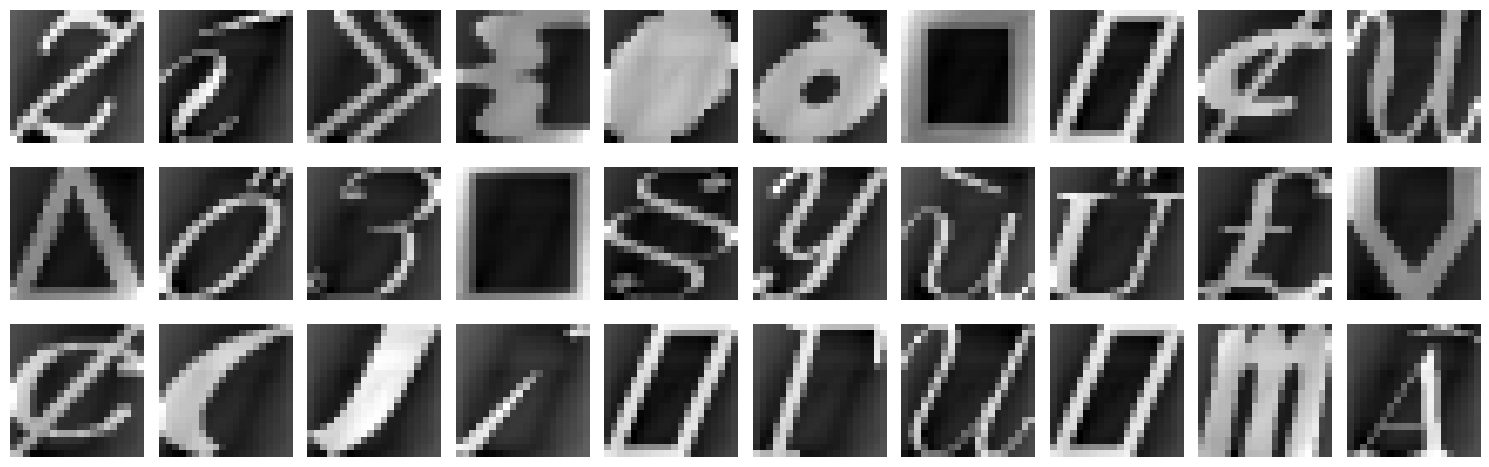

In [338]:
# Plot uncertain images, defined as the top 2 classes are within 5% difference in prbability
fig = plt.figure(figsize=(15, 5))
for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    plt.imshow(uncertain_images[i][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()

##### Step 4: Denoising

(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

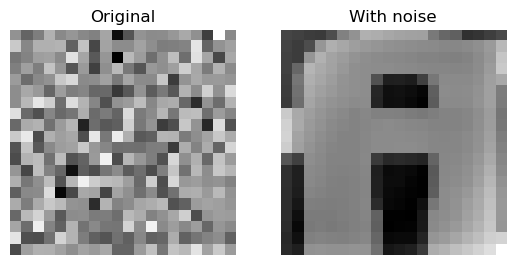

In [349]:
def make_noise(image):
    return image + np.random.normal(0, 10, image.shape)

noisey_images = []
for image in X:
    noisey_images.append(make_noise(image))
noisey_images = np.array(noisey_images)

fig, ax = plt.subplots(1, 2)
ax[1].imshow(X[0], cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
ax[0].imshow(noisey_images[0], cmap='gray')
ax[1].set_title('With noise')
ax[1].axis('off')

In [360]:
class CnnAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encodedSize = 32

        self.c1Out = 10
        self.c2Out = 10

        # ENCODE
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) # Preserves 20x20 image
        self.pool1 = nn.MaxPool2d(2,2) # output 10x10
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1) # Preserves 10x10 image
        self.pool2 = nn.MaxPool2d(2,2) # output 5x5

        self.downscaledSize = 20//4 # two 2x2 pools results in input division by 4
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out

        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize)

        # DECODE
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)


    def compress(self, x):
        x = F.relu(self.pool1(self.cv1(x)))
        x = F.relu(self.pool2(self.cv2(x)))
        x = x.view(-1, self.flattenedSize)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        x = F.relu(self.cv3(self.upsample1(x)))
        x = self.cv4(self.upsample2(x))

        return x

    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)

        return x

device = "cpu" # still way slower to use mps for this model ("mps" if torch.backends.mps.is_available() else "cpu")
cnnEncoder = CnnAutoEncoder().to(device=device) # treat these as just 28 D vectors

In [382]:
criterion = nn.MSELoss()

def trainCNN(model, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loader = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

    for epoch in range(epochs):
        loss = 0

        running_loss = 0

        for noisey, clean in train_loader:
            optimizer.zero_grad()

            outputs = model(noisey)
            train_loss = criterion(outputs, clean)

            train_loss.backward()
            optimizer.step()

            loss += train_loss.item()

            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        # compute the epoch training loss
        loss = loss / len(train_loader)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

In [383]:
X_noisy_tensor = torch.from_numpy(noisey_images).float().reshape(-1, 1, 20, 20)
X_clean_tensor = torch.from_numpy(X).float().reshape(-1, 1, 20, 20)

combined_dataset = TensorDataset(X_noisy_tensor, X_clean_tensor)

In [384]:
trainCNN(cnnEncoder, 50, combined_dataset)

epoch : 1/50, loss = 0.98181224
epoch : 2/50, loss = 0.93482513
epoch : 3/50, loss = 0.91056884
epoch : 4/50, loss = 0.89139424
epoch : 5/50, loss = 0.87466364
epoch : 6/50, loss = 0.85998997
epoch : 7/50, loss = 0.84234874
epoch : 8/50, loss = 0.82890215
epoch : 9/50, loss = 0.81792846
epoch : 10/50, loss = 0.79714569
epoch : 11/50, loss = 0.77749069
epoch : 12/50, loss = 0.76374403
epoch : 13/50, loss = 0.74828116
epoch : 14/50, loss = 0.73197915
epoch : 15/50, loss = 0.71824055
epoch : 16/50, loss = 0.70584743
epoch : 17/50, loss = 0.69396753
epoch : 18/50, loss = 0.68239594
epoch : 19/50, loss = 0.67028764
epoch : 20/50, loss = 0.65960933
epoch : 21/50, loss = 0.64678317
epoch : 22/50, loss = 0.63989259
epoch : 23/50, loss = 0.63387417
epoch : 24/50, loss = 0.62208896
epoch : 25/50, loss = 0.61772884
epoch : 26/50, loss = 0.60708107
epoch : 27/50, loss = 0.60010363
epoch : 28/50, loss = 0.59730404
epoch : 29/50, loss = 0.58397411
epoch : 30/50, loss = 0.57632552
epoch : 31/50, loss

In [385]:
def drawComparisonsCNN(model):
    test_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 6))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):
                #draw the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                #and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

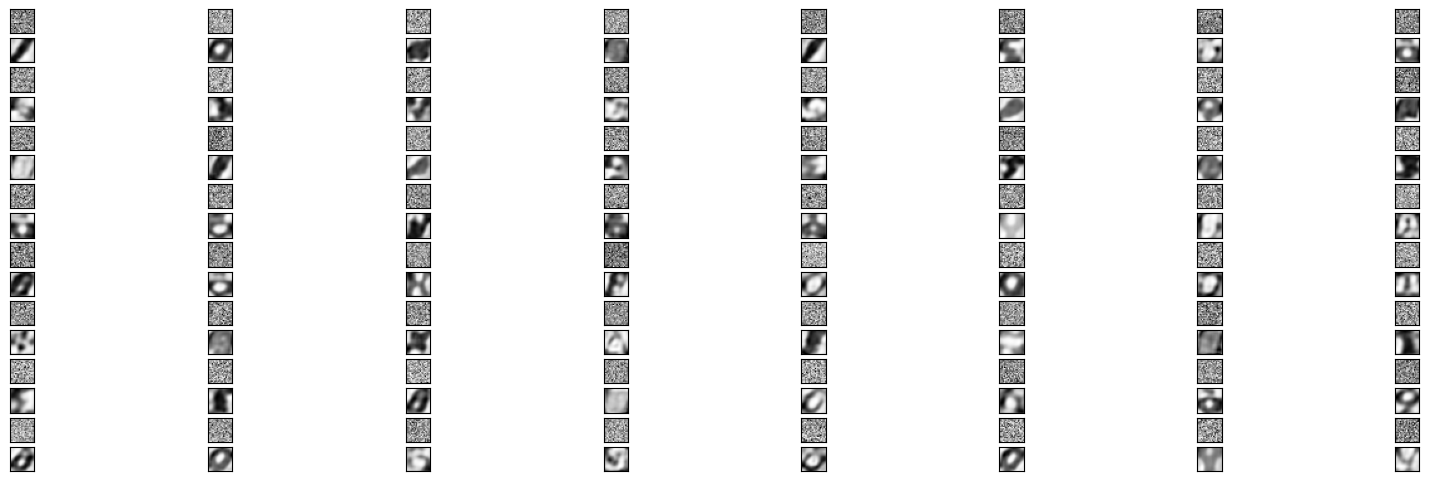

In [386]:
drawComparisonsCNN(cnnEncoder)